In [33]:
import tensorflow as tf
import keras
from keras.applications import InceptionV3,MobileNetV2
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.layers import Convolution2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, Lambda
import matplotlib.pyplot as plt
import pickle
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [2]:
#The dataset is obtained from the following google drive link
#https://drive.google.com/drive/folders/1Si9hduU-WYC63p91C2SJVUKZ3IPtsdJm?usp=sharing

In [3]:
#The links to the google drive directory
train = '/content/drive/My Drive/data/train'
valid = '/content/drive/My Drive/data/val'
test = '/content/drive/My Drive/data/test'

In [4]:
#Define the image size
image_size = [224,224]

In [5]:
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)


# add preprocessing layer to the front of mobilenet. We can remove the top and last layer of Mobilenetv2 model as we don't train them. 
conv_base = tf.keras.applications.InceptionV3(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

#No need to retrain the model since we directly use the imagenet weights
conv_base.trainable = False
conv_base.summary()
#Adding the output fully connected layer with 10 nodes, and softmax activation. 
#Apart from that I have included a flatten layer following the convolutional base. 
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(500,activation=('relu')))
model1.add(Dropout(0.4))
model1.add(BatchNormalization())
model1.add(Dense(4,activation=('softmax')))


model1.summary()

#Compile the model
model1.compile(
  loss='categorical_crossentropy',
  optimizer=adam,
  metrics=['accuracy']
)

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [6]:

#Adding data augmentation to the training images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#Rescaling or normalising the pixels in the image
test_datagen = ImageDataGenerator(
        rescale=1./255)

val_datagen = ImageDataGenerator(
        rescale=1./255)

#Using the flow from directory method to read the images directly from the google drive
train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/My Drive/data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    directory='/content/drive/My Drive/data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 1951 images belonging to 4 classes.
Found 18 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [7]:
#Model fitting stage
history = model1.fit_generator(train_generator,
                               epochs = 10, 
                               validation_data = val_generator,
                               steps_per_epoch = len(train_generator),
                               validation_steps = len(val_generator))

#The first epoch consumed the longest time.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
61/61 [==============================] - 1139s 19s/step - loss: 0.6058 - accuracy: 0.7893 - val_loss: 0.3180 - val_accuracy: 0.8642
Epoch 2/10
61/61 [==============================] - 38s 624ms/step - loss: 0.3082 - accuracy: 0.8862 - val_loss: 0.3131 - val_accuracy: 0.8765
Epoch 3/10
61/61 [==============================] - 38s 615ms/step - loss: 0.2523 - accuracy: 0.9031 - val_loss: 0.2198 - val_accuracy: 0.9105
Epoch 4/10
61/61 [==============================] - 37s 606ms/step - loss: 0.2058 - accuracy: 0.9247 - val_loss: 0.1933 - val_accuracy: 0.9321
Epoch 5/10
61/61 [==============================] - 37s 600ms/step - loss: 0.1990 - accuracy: 0.9308 - val_loss: 0.2098 - val_accuracy: 0.9228
Epoch 6/10
61/61 [==============================] - 37s 600ms/step - loss: 0.1625 - accuracy: 0.9446 - val_loss: 0.1440 - val_accuracy: 0.9444
Epoch 7/10
61/61 [==============================] - 36s 586ms/step

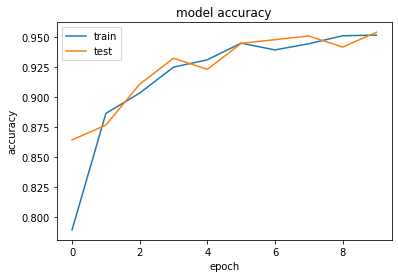

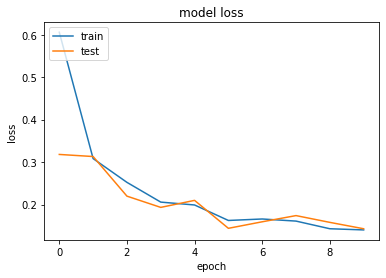

In [8]:
#Plotting the accuracy and loss
# summarize history for accuracy  
  

plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()
 
 # summarize history for loss  
  

plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [9]:
#Model evaluation
model1.evaluate_generator(generator=test_generator,
steps=len(test_generator))

#The test accuracy is 1.0 which is so far the highest acccuracy for tomota leaf disease classification

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.052667926996946335, 1.0]

In [12]:
#Saving the model
model1.save("cotton_incv3.h5")

In [13]:
#Loading the saved model
model1 = load_model("cotton_incv3.h5")

In [59]:
model1.evaluate_generator(generator=test_generator,
steps=len(test_generator))

[0.05266784876585007, 1.0]

In [101]:
img = image.load_img('/content/drive/My Drive/data/train/diseased cotton leaf/dis_leaf (121)_iaip.jpg',target_size=(224,224))

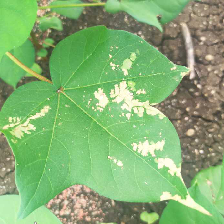

In [102]:
img

In [103]:
img = image.img_to_array(img)/255

img.shape

(224, 224, 3)

In [104]:
import numpy as np
x=np.expand_dims(img,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [106]:
pred = model1.predict(img_data)
pred

array([[0.41287664, 0.15639672, 0.05430473, 0.3764219 ]], dtype=float32)

In [100]:
np.argmax(pred)

0